Page toward data science sur le KNN présente tte la recommendation super bien donc à relire bcp


(long tail ...)

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

## Exemple d'utilisation :

In the following example, we construct a NeighborsClassifier class from an array representing our data set and ask who’s the closest point to [1,1,1]

In [2]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples) 
NearestNeighbors(algorithm='auto', leaf_size=30)
print( neigh.kneighbors([[1., 1., 1.]]))


(array([[0.5]]), array([[2]], dtype=int64))


As you can see, it returns [[0.5]], and [[2]], which means that the element is at distance 0.5 and is the third element of samples (indexes start at 0). You can also query for multiple points:

In [3]:
X = [[0., 1., 0.], [1., 0., 1.]]
neigh.kneighbors(X, return_distance=False)

array([[1],
       [2]], dtype=int64)

## Application à la recommendation

## Testons sur une matrice réelle : dataset de Kaggle

In [2]:
import pandas as pd

dataset = pd.read_csv("datatset_restaurant.csv")
print(dataset.head())

  userID  placeID  rating  food_rating  service_rating
0  U1077   135085       2            2               2
1  U1077   135038       2            2               1
2  U1077   132825       2            2               2
3  U1077   135060       1            2               2
4  U1068   135104       1            1               2


In [3]:
def to_matrice(dataset):
    # marche pour un dataset avec notes entre 0 et note max
    # à adapter sinon
    
    user = dataset.iloc[:, 0]
    item = dataset.iloc[:, 1]

    utile = dataset.iloc[:, 0:3]
    data_array = utile.get_values()  # to_numpy devient get_values sur python 3

    user_dict = {}
    for k in range(data_array.shape[0]):
        user_dict[data_array[k][0]] = data_array[k][1]
    nb_user = len(user_dict)

    item_dict = {}
    for k in range(data_array.shape[0]):
        item_dict[data_array[k][1]] = data_array[k][0]
    nb_item = len(item_dict)

    nb_ratings = data_array.shape[0]
    pourc = round(100 * nb_ratings / (nb_user * nb_item), 2)

    print("Il y a ", nb_user, " utilisateurs et ", nb_item, "plats et ", nb_ratings, "notes, soit une matrice ", pourc,
          "% pleine.")

    # Matrice note

    # on commence par remplir une matrice avec que des zeros ou des -1, à voir
    M = np.zeros((nb_user, nb_ratings))

    # Il faut maintenant réindexer
    # Stratégie :

    index = 0
    for cle in user_dict.keys():
        user_dict[cle] = index
        index += 1

    index = 0
    for cle in item_dict.keys():
        item_dict[cle] = index
        index += 1

    for x in data_array:
        user = user_dict.get(x[0])
        item = item_dict.get(x[1])
        rating = x[2]
        M[user][item] = rating + 1  # je fais donc des notes de 1 à 3 et on laisse 0 pour les non notés

    return M

In [4]:
data=to_matrice(dataset)

Il y a  138  utilisateurs et  130 plats et  1161 notes, soit une matrice  6.47 % pleine.


In [7]:
def knn (data, num_plat, nb_rec):
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=nb_rec+1, n_jobs=-1)
# voir pq on a choisi la distance cosine
    model.fit(data)
    distances, indices = model.kneighbors(data[num_plat:num_plat+1,:] , n_neighbors=nb_rec+1)
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    raw_recommends.reverse()
    k=0
    for couple in raw_recommends : 
        k+=1
        print( "recommendation numéro ", k, " : plat numéro " , couple[0])

In [8]:
knn(data,12,10)

recommendation numéro  1  : plat numéro  3
recommendation numéro  2  : plat numéro  1
recommendation numéro  3  : plat numéro  132
recommendation numéro  4  : plat numéro  130
recommendation numéro  5  : plat numéro  129
recommendation numéro  6  : plat numéro  28
recommendation numéro  7  : plat numéro  2
recommendation numéro  8  : plat numéro  6
recommendation numéro  9  : plat numéro  8
recommendation numéro  10  : plat numéro  9


# A la mano :

In [5]:
def table_distance(M,num_col):
    j=num_col
    distance=[]
    #distance est une liste de couple (distance a la colone "num_col", numéro de la colonne)
    for k in range(M.shape[1]) :
        distance.append((1-np.vdot(M.T[j],M.T[k])/(np.linalg.norm(M.T[j])*np.linalg.norm(M.T[k])),k))
    distance=sorted(distance)
    return distance


def KNN_voisins (M,item,K):
    if K >= M.shape[1] :
        raise Exception ("Vous demandez plus de voisins qu'il n'y a d'item dans la matrice de départ")
    distance=table_distance(M,item)
    for k in range(1, K+1): # on enlève le premier qui correspond à lui meme
        print(k, " : item numéro ",distance[k][1], " -----  distance de : ", distance[k][0])



def KNN_note(M,item,K,user):
    if M[user][item] !=0 :
        return M[user][item]
    distance = table_distance(M, item)
    note=0
    non_nul=K-1
    print ("les items les plus proches, notés par cet utilisateur, sont : ")  
    for k in range(1,K):
        num_voisin= distance[k][1]
        note_voisin=M[user][num_voisin]
        if note_voisin == 0 :
            non_nul-=1
        else :
            print("item numéro ", num_voisin, "avec une note de ", note_voisin)
            note+=note_voisin     
    return note/non_nul


def KNN_remplissage(M,K):
    for user in range(M.shape[0]):
        print("etape ", user, " sur ", M.shape[0])
        for item in range(M.shape[1]):
            if M[user][item] == 0:
                note=KNN_note(M,item,K,user)
                M[user][item]=note
    return M



## Matrice cas limite

In [57]:
M = rd.random((10001,1001))
#on fait d'abord une matrice vide à 30%
n,m = M.shape
for i in range (n):
    for j in range(m):
        if M[i][j]<.3:
            M[i][j]=0
        else : 
            M[i][j]=1

#on met des 1 et des 5 par blocs
for i in range (n//2+1) : 
    for j in range (m//2+1) :
        if M[i][j]==1:
            M[i][j]=5
            
for i in range (n//2+1,n) : 
    for j in range (m//2+1,m) :
        if M[i][j]==1:
            M[i][j]=5
            
print (M)

[[0. 5. 5. ... 0. 1. 0.]
 [5. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 5. 5. 0.]
 [0. 1. 1. ... 5. 5. 0.]
 [0. 1. 1. ... 5. 5. 0.]]


In [58]:
item=0
user=0
K=15

In [59]:
KNN_note(M,item,K,user)

les items les plus proches, notés par cet utilisateur, sont : 
item numéro  7 avec une note de  5.0
item numéro  274 avec une note de  5.0
item numéro  114 avec une note de  5.0
item numéro  324 avec une note de  5.0
item numéro  439 avec une note de  5.0
item numéro  244 avec une note de  5.0


5.0

## Dataset de Kaggle

In [9]:
M=data

In [10]:
print(M)

[[3. 3. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
item=0
user=1
K=300

In [16]:
KNN_note(M,item,K,user)

les items les plus proches, notés par cet utilisateur, sont : 
item numéro  4 avec une note de  2.0
item numéro  5 avec une note de  1.0
item numéro  6 avec une note de  2.0
item numéro  7 avec une note de  1.0
item numéro  8 avec une note de  2.0
item numéro  10 avec une note de  2.0
item numéro  14 avec une note de  1.0
item numéro  23 avec une note de  2.0


C:\Users\danbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


1.625

## Etude plus poussée avec le dataset

### Plot note en fonction de K

In [24]:
def KNN_note_2(M,item,K,user):
    distance = table_distance(M, item)
    note=0
    non_nul=K-1
    for k in range(1,K):
        num_voisin= distance[k][1]
        note_voisin=M[user][num_voisin]
        if note_voisin == 0 :
            non_nul-=1
        else :
            note+=note_voisin 
    if non_nul!=0:
        return note/non_nul
    else :
        return 0

In [25]:
item=0
user=1

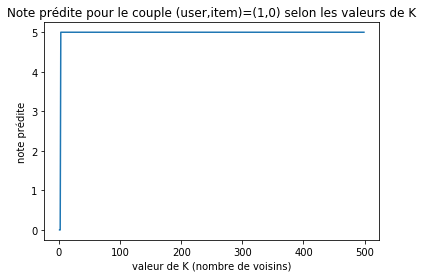

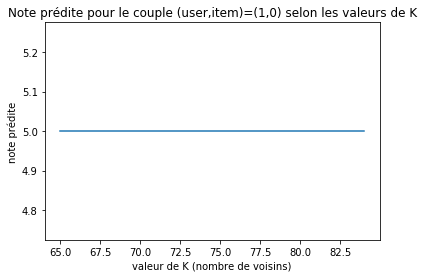

In [26]:
K_liste=[]
note_liste=[]
for K in range (1,500,1):
    K_liste.append(K)
    note_liste.append(KNN_note_2(M,item,K,user))
    
plt.plot(K_liste,note_liste)
plt.xlabel("valeur de K (nombre de voisins)")
plt.ylabel("note prédite")
plt.title("Note prédite pour le couple (user,item)=(1,0) selon les valeurs de K")
plt.show()

K_liste=[]
note_liste=[]
for K in range (65,85,1):
    K_liste.append(K)
    note_liste.append(KNN_note_2(M,item,K,user))
    
plt.plot(K_liste,note_liste)
plt.xlabel("valeur de K (nombre de voisins)")
plt.ylabel("note prédite")
plt.title("Note prédite pour le couple (user,item)=(1,0) selon les valeurs de K")
plt.show()

In [27]:
M = rd.random((10001,1001))
#on fait d'abord une matrice vide à 30%
n,m = M.shape
for i in range (n):
    for j in range(m):
        if M[i][j]<.3:
            M[i][j]=0
        else : 
            M[i][j]=1

#on met des 1 et des 5 par blocs
for i in range (n//2+1) : 
    for j in range (m//2+1) :
        if M[i][j]==1:
            M[i][j]=5
            
for i in range (n//2+1,n) : 
    for j in range (m//2+1,m) :
        if M[i][j]==1:
            M[i][j]=5
            
print (M)

[[5. 5. 5. ... 1. 1. 1.]
 [5. 0. 5. ... 1. 1. 0.]
 [5. 5. 0. ... 0. 0. 1.]
 ...
 [0. 1. 1. ... 0. 0. 5.]
 [1. 0. 1. ... 0. 5. 5.]
 [1. 0. 1. ... 5. 5. 5.]]


In [28]:
user = 1
item = 1

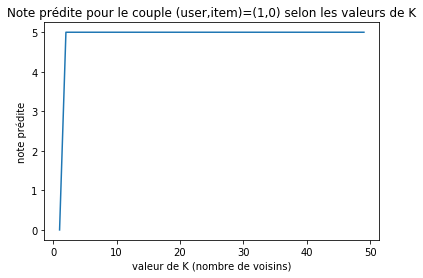

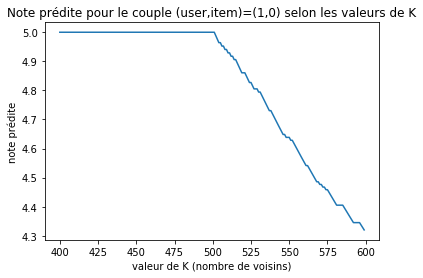

In [31]:
K_liste=[]
note_liste=[]
for K in range (1,50,1):
    K_liste.append(K)
    note_liste.append(KNN_note_2(M,item,K,user))
    
plt.plot(K_liste,note_liste)
plt.xlabel("valeur de K (nombre de voisins)")
plt.ylabel("note prédite")
plt.title("Note prédite pour le couple (user,item)=(1,0) selon les valeurs de K")
plt.show()

K_liste=[]
note_liste=[]
for K in range (400,600,1):
    K_liste.append(K)
    note_liste.append(KNN_note_2(M,item,K,user))
    
plt.plot(K_liste,note_liste)
plt.xlabel("valeur de K (nombre de voisins)")
plt.ylabel("note prédite")
plt.title("Note prédite pour le couple (user,item)=(1,0) selon les valeurs de K")
plt.show()

In [7]:
def KNN_note_bis(M,item,K,user):
    distance = table_distance(M, item)
    note=0
    non_nul=K-1 
    for k in range(1,K):
        num_voisin= distance[k][1]
        note_voisin=M[user][num_voisin]
        if note_voisin == 0 :
            non_nul-=1
        else :
            note+=note_voisin     
    if non_nul==0:
        return False
    else :
        return True

Rappel : Il y a  138  utilisateurs et  130 plats et  1161 notes, soit une matrice  6.47 % pleine.

In [8]:
def correct(M,K):
    p=0
    n,m=M.shape
    n_tot=0
    for user in range(n):
        for item in range(m):
            x=rd.random()
            if x>.8:
                n_tot+=1
                if KNN_note_bis(M,item,K,user) : 
                    p+=1

    return p/n_tot 

In [ ]:
K_liste=[]
p_liste=[]
for K in range(1,500,10):
    K_liste.append(K)
    p_liste.append(correct(M,K))

plt.plot(K_liste,p_liste)
plt.show()

C:\Users\danbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
